In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
from dataclasses import dataclass

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from google.cloud import bigquery
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split

from queries import FETCH_DATASET_FLAT 
from configurations import (TARGET, TEST_DATASET_SHARE, RANDOM_STATE, CATEGORICAL_FEATRUES, MODEL_PARAMS,
                            FIT_PARAMS, CROSS_VALIDATION_FOLDS, FEATRURES_TO_IGNORE_WHILE_TRAIN, HYPERPARAM_ROUNDS)


@dataclass
class RawData:
    X_train: pd.DataFrame
    X_test: pd.Series
    y_train: pd.DataFrame
    y_test: pd.Series
    
@dataclass
class TrainingReady:
    rawdata: RawData
    features: list
    

def import_engagements() -> RawData:
    """
    """
    client = bigquery.Client()
    
    engagements = client.query(FETCH_DATASET_FLAT).to_dataframe()
    
    X = engagements[engagements.columns.difference([TARGET])]
    y = engagements[TARGET]
        
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        stratify=y,
        test_size=TEST_DATASET_SHARE,
        random_state=RANDOM_STATE
    )
        
    
    return RawData(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)



def one_hot_encode(rawdata: RawData, min_frequency: float = 0.05, max_categories: int = 15) -> TrainingReady:
    """
    """
    for feature in CATEGORICAL_FEATRUES:
        # extract relevant categories
        series = rawdata.X_train[feature]
        series_ratios = series.value_counts(normalize=True).to_frame().head(max_categories)
        categories = series_ratios[series_ratios[series.name] >= min_frequency].index.tolist()
        
        # add dummies to train
        dummmies_train = pd.get_dummies(
            series.astype(pd.CategoricalDtype(categories=categories)),
            prefix=series.name
        )        
        
        rawdata.X_train = pd.concat([rawdata.X_train, dummmies_train], axis=1).drop(columns=feature)
        
        # add dummies to test
        series = rawdata.X_test[feature]
        dummmies_test = pd.get_dummies(
            series.astype(pd.CategoricalDtype(categories=categories)),
            prefix=series.name
        )
        
        rawdata.X_test = pd.concat([rawdata.X_test, dummmies_test], axis=1).drop(columns=feature)
    
    # extract and sort features for training
    features = sorted(rawdata.X_train.columns.difference(FEATRURES_TO_IGNORE_WHILE_TRAIN))
    
    return TrainingReady(rawdata=rawdata, features=features)


def exe_optimal_gbm(training_ready: TrainingReady):
    """
    """
    rawdata = training_ready.rawdata
    features = training_ready.features
                         
    param_grid = {
        **MODEL_PARAMS, 
        **{'scale_pos_weight': [np.sum(rawdata.y_train==0)/rawdata.y_train.sum(), np.sqrt(np.sum(rawdata.y_train==0)/rawdata.y_train.sum())]}
    }
    
    fit_params = {
        **FIT_PARAMS,
        **{'eval_set': [(rawdata.X_test[features], rawdata.y_test)]}
    }
    
    f2_scorer = make_scorer(fbeta_score, beta=2)
    
    estimator = XGBClassifier()
    
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_grid,
        scoring=f2_scorer,   # roc_auc
        n_iter=HYPERPARAM_ROUNDS,
        cv=StratifiedKFold(n_splits=CROSS_VALIDATION_FOLDS),
        n_jobs=-1
    )
    
    random_search.fit(rawdata.X_train[features], rawdata.y_train)
    
    optimal_estimator = XGBClassifier(**random_search.best_params_)
    optimal_estimator.fit(rawdata.X_train[features], rawdata.y_train, **fit_params)
        
    return optimal_estimator, random_search

In [30]:
%%time
rawdata = import_engagements()
training_ready = one_hot_encode(rawdata)
optimal_estimator, random_search = exe_optimal_gbm(training_ready)

# Analyze results

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1296x864 with 0 Axes>

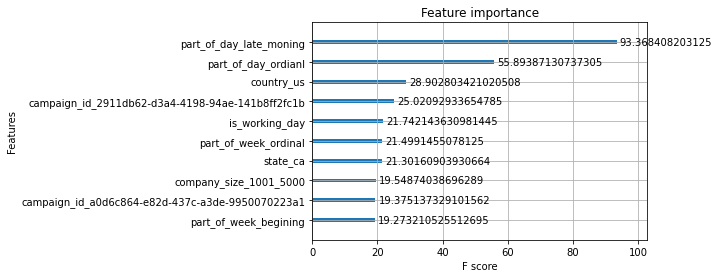

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,12))
plot_importance(optimal_estimator, max_num_features=10, importance_type='gain')

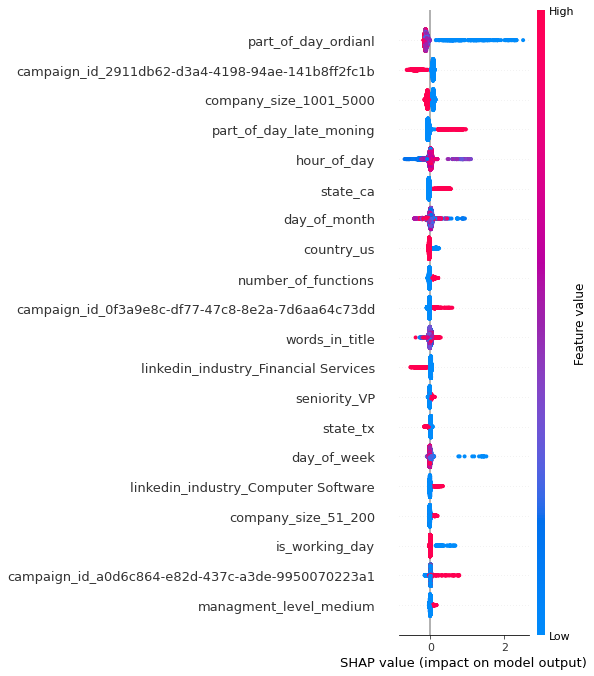

In [53]:
import shap
explainer = shap.TreeExplainer(optimal_estimator)
shap_values = explainer.shap_values(training_ready.rawdata.X_test[training_ready.features])
shap.summary_plot(shap_values, training_ready.rawdata.X_test[training_ready.features])